# CutMix and MixUp

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Data

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
ds_info.features["label"].names[:10]

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound']

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [6]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


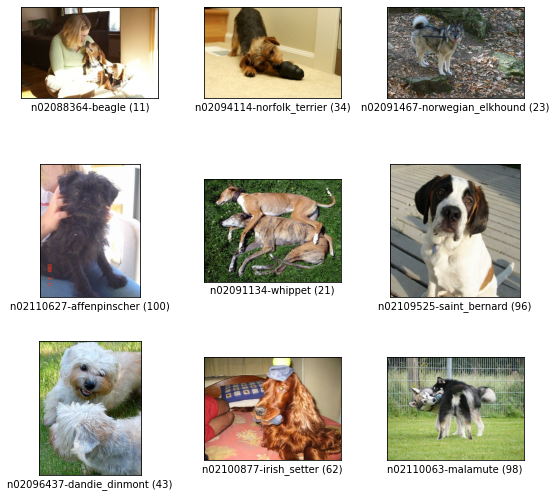

In [7]:
fig = tfds.show_examples(ds_info, ds_train)

## Cutmix

In [8]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [9]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [10]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [11]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup

In [12]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [13]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Augmentation

In [14]:
def onehot(image,label):
    CLASSES = 120
    return image,tf.one_hot(label,CLASSES)

In [15]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2)
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## Model

## no augumetation model

In [16]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## basic augumetation model

In [17]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## cutmix model

In [18]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## mixup model

In [19]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [21]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

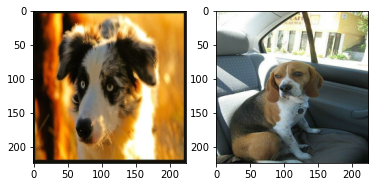

In [22]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [23]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.52933675
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.47066325 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

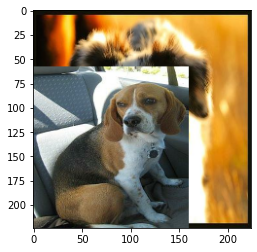

In [24]:
# cutmix image&label
xa, ya, xb, yb = get_clip_box(image_a, image_b)
cutmix_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(cutmix_img)

cutmix_label = mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120)
print(cutmix_label)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.8165047
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.18349528 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

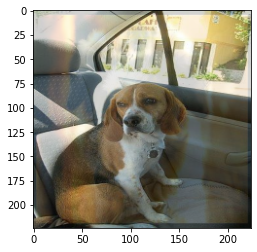

In [25]:
# mixup image&label
mixed_image, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_image)
print(mixed_label)

## Train

In [26]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
tf.random.set_seed(2020)

## no augmentation model

In [28]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 410s 541ms/step - loss: 1.4593 - accuracy: 0.6205 - val_loss: 1.4853 - val_accuracy: 0.5743
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 0.7108 - accuracy: 0.8073 - val_loss: 1.1016 - val_accuracy: 0.6772
Epoch 3/20
750/750 [==============================] - 115s 153ms/step - loss: 0.2464 - accuracy: 0.9466 - val_loss: 0.9300 - val_accuracy: 0.7261
Epoch 4/20
750/750 [==============================] - 115s 153ms/step - loss: 0.0971 - accuracy: 0.9876 - val_loss: 0.9248 - val_accuracy: 0.7392
Epoch 5/20
750/750 [==============================] - 121s 161ms/step - loss: 0.0451 - accuracy: 0.9961 - val_loss: 0.9536 - val_accuracy: 0.7332
Epoch 6/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0259 - accuracy: 0.9982 - val_loss: 0.9360 - val_accuracy: 0.7383
Epoch 7/20
750/750 [==============================] - 117s 155ms/step - loss: 0.0236 - accuracy: 0.9979 - val_loss: 0.9460 -

## basic augmentation model

In [29]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 117s 151ms/step - loss: 3.2460 - accuracy: 0.2789 - val_loss: 3.2072 - val_accuracy: 0.2362
Epoch 2/20
750/750 [==============================] - 112s 150ms/step - loss: 1.1058 - accuracy: 0.6793 - val_loss: 1.2724 - val_accuracy: 0.6328
Epoch 3/20
750/750 [==============================] - 112s 150ms/step - loss: 0.6246 - accuracy: 0.8200 - val_loss: 1.1806 - val_accuracy: 0.6537
Epoch 4/20
750/750 [==============================] - 112s 150ms/step - loss: 0.3564 - accuracy: 0.9048 - val_loss: 1.1719 - val_accuracy: 0.6652
Epoch 5/20
750/750 [==============================] - 112s 150ms/step - loss: 0.1989 - accuracy: 0.9527 - val_loss: 1.0008 - val_accuracy: 0.7160
Epoch 6/20
750/750 [==============================] - 112s 150ms/step - loss: 0.1057 - accuracy: 0.9806 - val_loss: 1.0001 - val_accuracy: 0.7148
Epoch 7/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0922 - accuracy: 0.9835 - val_loss: 1.0492 -

## cutmix model

In [30]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 119s 152ms/step - loss: 4.3308 - accuracy: 0.1182 - val_loss: 3.1815 - val_accuracy: 0.2347
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 3.0601 - accuracy: 0.3951 - val_loss: 1.4327 - val_accuracy: 0.5986
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 2.6831 - accuracy: 0.5272 - val_loss: 1.2254 - val_accuracy: 0.6461
Epoch 4/20
750/750 [==============================] - 114s 152ms/step - loss: 2.5019 - accuracy: 0.5823 - val_loss: 1.2442 - val_accuracy: 0.6522
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 2.3386 - accuracy: 0.6225 - val_loss: 1.4069 - val_accuracy: 0.6166
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 2.2165 - accuracy: 0.6707 - val_loss: 1.1777 - val_accuracy: 0.6744
Epoch 7/20
750/750 [==============================] - 114s 152ms/step - loss: 2.1218 - accuracy: 0.6915 - val_loss: 1.2225 -

## mixup model

In [31]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 120s 153ms/step - loss: 4.3009 - accuracy: 0.1248 - val_loss: 3.9364 - val_accuracy: 0.1336
Epoch 2/20
750/750 [==============================] - 115s 153ms/step - loss: 2.9759 - accuracy: 0.4339 - val_loss: 1.6201 - val_accuracy: 0.5570
Epoch 3/20
750/750 [==============================] - 114s 153ms/step - loss: 2.6284 - accuracy: 0.5617 - val_loss: 1.3853 - val_accuracy: 0.6119
Epoch 4/20
750/750 [==============================] - 114s 153ms/step - loss: 2.4563 - accuracy: 0.6366 - val_loss: 1.3444 - val_accuracy: 0.6339
Epoch 5/20
750/750 [==============================] - 115s 153ms/step - loss: 2.3195 - accuracy: 0.6844 - val_loss: 1.4079 - val_accuracy: 0.6198
Epoch 6/20
750/750 [==============================] - 114s 153ms/step - loss: 2.2074 - accuracy: 0.7192 - val_loss: 1.1808 - val_accuracy: 0.6726
Epoch 7/20
750/750 [==============================] - 115s 153ms/step - loss: 2.1446 - accuracy: 0.7522 - val_loss: 1.3631 -

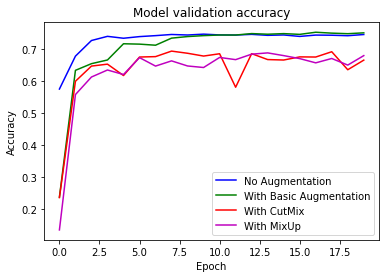

In [32]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.show()


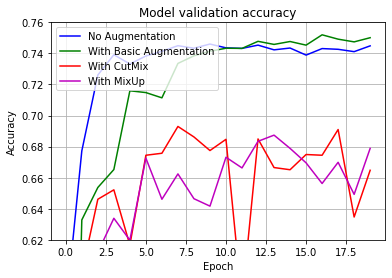

In [33]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.grid(True)

plt.ylim(0.62, 0.76)  
plt.show()

- cutmix와 mixup로 Data augmentation한 모델의 성능이 augmentation하지 않은 모델과 basic augmentation 모델보다 낮게 나왔습니다.
- cutmix와 mixup의 성능이 더 좋을 것으로 생각이 되는데 그 반대로 나온 원인을 추정해보면 다음과 같다. 학습에 사용된 stanford_dogs 데이터셋의 양이 20,580개인데 cutmix가 적용된 논문에 사용한 데이터셋은 cifar100으로 60000개로 학습에 사용된 데이터가 부족하여 cutmix와 mixup을 적용하여도 학습이 덜 된 것으로 생각이 된다. 학습 데이터셋의 양을 증가시키면 결과가 달라질 것 같다. cifar 10 데이터셋으로 학습시켜보겠다.

## cifar 10 데이터셋

In [34]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


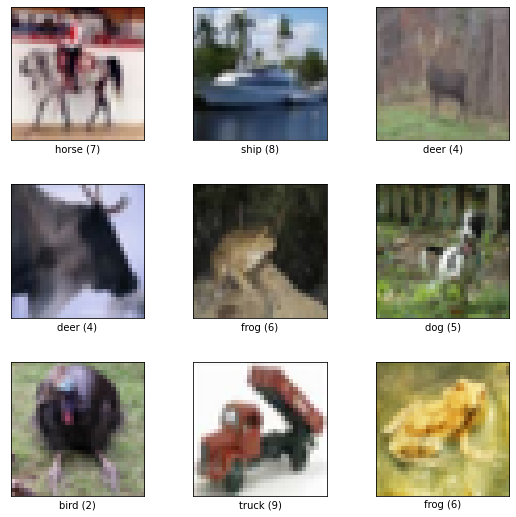

In [35]:
fig = tfds.show_examples(ds_info, ds_train)

In [36]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])


In [37]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

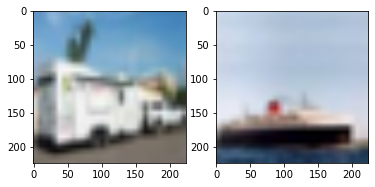

In [38]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [39]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.35624602 0.643754   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

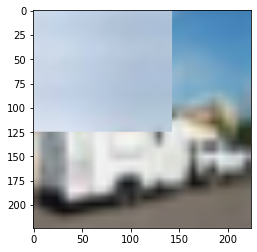

In [40]:
# cutmix image&label
xa, ya, xb, yb = get_clip_box(image_a, image_b)
cutmix_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(cutmix_img)

cutmix_label = mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120)
print(cutmix_label)

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.9817301 0.0182699 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

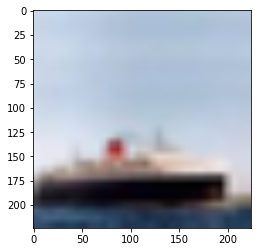

In [41]:
# mixup image&label
mixed_image, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_image)
print(mixed_label)

In [42]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
3125/3125 [==============================] - 414s 131ms/step - loss: 0.6034 - accuracy: 0.8100 - val_loss: 0.2016 - val_accuracy: 0.9300
Epoch 2/20
3125/3125 [==============================] - 410s 131ms/step - loss: 0.1202 - accuracy: 0.9586 - val_loss: 0.1854 - val_accuracy: 0.9420
Epoch 3/20
3125/3125 [==============================] - 410s 131ms/step - loss: 0.0218 - accuracy: 0.9944 - val_loss: 0.1562 - val_accuracy: 0.9553
Epoch 4/20
3125/3125 [==============================] - 410s 131ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.1519 - val_accuracy: 0.9613
Epoch 5/20
3125/3125 [==============================] - 410s 131ms/step - loss: 6.6291e-04 - accuracy: 1.0000 - val_loss: 0.1555 - val_accuracy: 0.9622
Epoch 6/20
3125/3125 [==============================] - 410s 131ms/step - loss: 3.6567e-04 - accuracy: 1.0000 - val_loss: 0.1593 - val_accuracy: 0.9615
Epoch 7/20
3125/3125 [==============================] - 410s 131ms/step - loss: 2.6802e-04 - accuracy: 1

In [43]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
3125/3125 [==============================] - 414s 131ms/step - loss: 0.6259 - accuracy: 0.8036 - val_loss: 0.2014 - val_accuracy: 0.9333
Epoch 2/20
3125/3125 [==============================] - 410s 131ms/step - loss: 0.1659 - accuracy: 0.9436 - val_loss: 0.1790 - val_accuracy: 0.9404
Epoch 3/20
3125/3125 [==============================] - 410s 131ms/step - loss: 0.0605 - accuracy: 0.9804 - val_loss: 0.1811 - val_accuracy: 0.9497
Epoch 4/20
3125/3125 [==============================] - 410s 131ms/step - loss: 0.0435 - accuracy: 0.9861 - val_loss: 0.1713 - val_accuracy: 0.9503
Epoch 5/20
3125/3125 [==============================] - 410s 131ms/step - loss: 0.0274 - accuracy: 0.9919 - val_loss: 0.1573 - val_accuracy: 0.9552
Epoch 6/20
3125/3125 [==============================] - 410s 131ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.1538 - val_accuracy: 0.9595
Epoch 7/20
3125/3125 [==============================] - 410s 131ms/step - loss: 0.0103 - accuracy: 0.9972 - val_

In [44]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
3125/3125 [==============================] - 421s 133ms/step - loss: 1.5670 - accuracy: 0.5892 - val_loss: 0.3185 - val_accuracy: 0.9144
Epoch 2/20
3125/3125 [==============================] - 416s 133ms/step - loss: 1.0459 - accuracy: 0.8019 - val_loss: 0.2649 - val_accuracy: 0.9383
Epoch 3/20
3125/3125 [==============================] - 416s 133ms/step - loss: 1.0375 - accuracy: 0.8023 - val_loss: 0.2430 - val_accuracy: 0.9422
Epoch 4/20
3125/3125 [==============================] - 416s 133ms/step - loss: 0.9661 - accuracy: 0.8124 - val_loss: 0.1893 - val_accuracy: 0.9541
Epoch 5/20
3125/3125 [==============================] - 416s 133ms/step - loss: 0.8354 - accuracy: 0.8647 - val_loss: 0.2196 - val_accuracy: 0.9471
Epoch 6/20
3125/3125 [==============================] - 416s 133ms/step - loss: 0.8880 - accuracy: 0.8359 - val_loss: 0.1887 - val_accuracy: 0.9569
Epoch 7/20
3125/3125 [==============================] - 416s 133ms/step - loss: 0.7861 - accuracy: 0.8651 - val_

In [45]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
3125/3125 [==============================] - 426s 135ms/step - loss: 1.5337 - accuracy: 0.6273 - val_loss: 0.3408 - val_accuracy: 0.9158
Epoch 2/20
3125/3125 [==============================] - 420s 134ms/step - loss: 1.0540 - accuracy: 0.8249 - val_loss: 0.3130 - val_accuracy: 0.9260
Epoch 3/20
3125/3125 [==============================] - 441s 141ms/step - loss: 1.0442 - accuracy: 0.8234 - val_loss: 0.2610 - val_accuracy: 0.9376
Epoch 4/20
3125/3125 [==============================] - 419s 134ms/step - loss: 0.8684 - accuracy: 0.8883 - val_loss: 0.2917 - val_accuracy: 0.9292
Epoch 5/20
3125/3125 [==============================] - 498s 159ms/step - loss: 0.9686 - accuracy: 0.8453 - val_loss: 0.2536 - val_accuracy: 0.9455
Epoch 6/20
3125/3125 [==============================] - 441s 141ms/step - loss: 0.8136 - accuracy: 0.9006 - val_loss: 0.2677 - val_accuracy: 0.9399
Epoch 7/20
3125/3125 [==============================] - 441s 141ms/step - loss: 0.9190 - accuracy: 0.8627 - val_

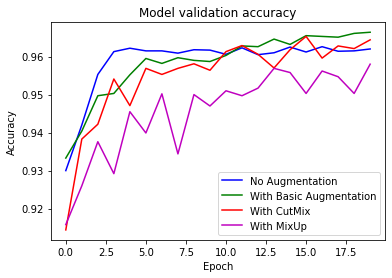

In [46]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.show()

- stanford dogs 데이터셋에 비하여 cutmix와 mixup 모델의 성능이 향상된 것을 관측할 수 있다. 기존에는 validation accuracy가 70%에 미치지 못하였는데 현재는 모든 모델의 validation accuracy가 95%이상이다. 그러나 여전히 성능이 no augmentation과 basic augmentation에 비하여 낮은데 augmentation의 목적을 살펴보면 알 수 있다.
- augmentation은 원본데이터를 포함한 augmentation 데이터셋을 더해주는 것인데 본 프로젝트에서는 원본데이터를 포함하지 않고 augmentation 데이터셋으로만 모델을 학습시켰다. 따라서 augmetation 효과를 제대로 나타내지 못했다.
- 원본 데이터셋과 augmentation 데이터를 포함한 것으로 학습을 시킨다면 더 좋은 성능을 낼 것이다.